<a href="https://colab.research.google.com/github/devanshjoshi104/Andrej-YT-Lecture/blob/main/Lecture1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
class Node:
  def __init__(self, data, _children = (), _op = '', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Node(data = {self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Node(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Node(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Node(self.data**other, (self,), f'**{other}')
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def backward(self):

    topo_set = []
    visited = set()
    def build_topological_set(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topological_set(child)
        topo_set.append(v)
    build_topological_set(self)

    self.grad = 1.0
    for node in reversed(topo_set):
      node._backward()

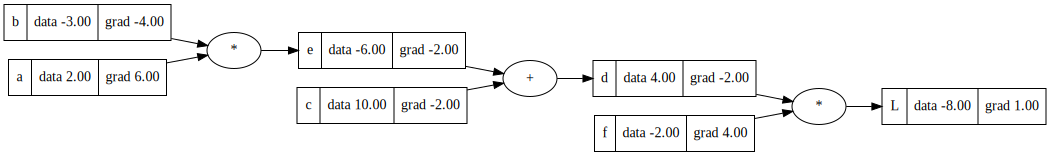

In [11]:
a = Node(2.0, label='a')
b = Node(-3.0, label='b')
c = Node(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Node(-2.0, label='f')
L = d * f; L.label = 'L'
L.grad = 1.0
L.backward()
draw_dot(L)

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.2f  | grad %.2f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [12]:
import torch

In [13]:
class Neuron:

  def __init__(self, nin):
    self.w = [Node(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Node(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

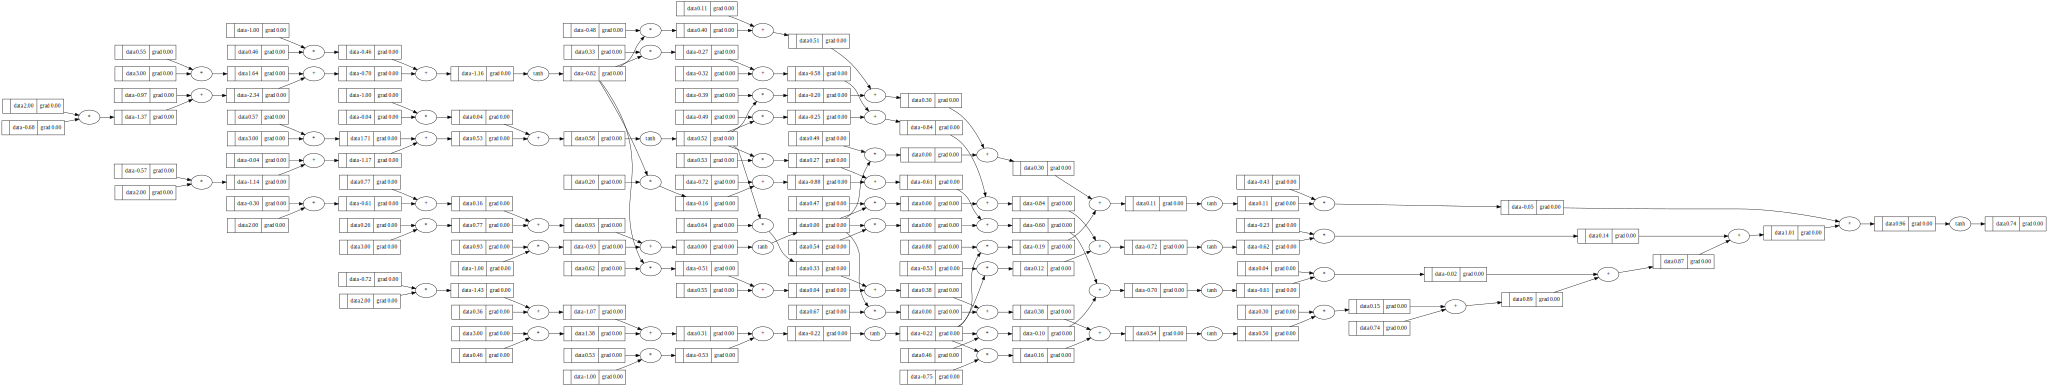

In [15]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
draw_dot(n(x))

# New section

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)
